Introduction

Methodology
1. Data Cleaning
2. Data Manipulation
3. EDA(Explanatory Data Analysis)
4. Model Deployment (4 models)
5. Model Robustness Testing / Sensitivity Check
6. Model Evaluation (Accuracy)
7. Model Selection and Finalization (Sensitivity and Accuracy Matrix)

Alorithms Tested
1. KNN
2. DT
3. RF
4. SVM

Conclusion:

# Importing Libraries

In [86]:
# import the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, validation_curve
from sklearn.metrics import recall_score
from sklearn import tree
%matplotlib inline
import matplotlib.ticker as mtick

import warnings
warnings.filterwarnings("ignore")

# Reading Dataset

In [2]:
# accessing the data
data = pd.read_csv('accute_inflammation.csv')

In [3]:
data.columns = ['Temp','Nausea','Lumbar','Urine','Micturition','Burning','Inflammation','Nephritis']

In [4]:
data.head(5)

,Temp,Nausea,Lumbar,Urine,Micturition,Burning,Inflammation,Nephritis
0,35.3,no,yes,no,no,no,no,no
1,35.3,no,no,yes,yes,yes,yes,no
2,35.3,no,yes,no,no,no,no,no
3,36.3,no,no,yes,yes,yes,yes,no
4,36.3,no,yes,no,no,no,no,no


# Processing and Data Cleanup

Within the dataset, there are four possible outcomes. A patient can have Inflammation, have Nephritis, have both or have neither. Currently, the outcome is shown in two columns (Inflamation and Nephritis). A target column is created to show all the four outcomes in one column

In [5]:
# created a target column with zeros
data['target'] = data.apply(lambda _: 0 , axis=1)

# polupate target column using information in columns Inflammation and Nephritis
for x in range(120):
    if  data['Inflammation'][x] == "yes" and data['Nephritis'][x] == "no":
        data['target'][x] = 1
    elif data['Inflammation'][x] == "no" and data['Nephritis'][x] == "yes":
        data['target'][x] = 2
    elif data['Inflammation'][x] == "yes" and data['Nephritis'][x] == "yes":
        data['target'][x] = 3
    else:
        data['target'][x] = 4

In [6]:
# replace "yes" and "no" to 1 and 0
dataset = data.replace(to_replace = ['yes','no'],value = [1,0])

In [7]:
dataset.drop(columns=['Inflammation','Nephritis'], inplace=True)
dataset.head(3)

,Temp,Nausea,Lumbar,Urine,Micturition,Burning,target
0,35.3,0,1,0,0,0,4
1,35.3,0,0,1,1,1,1
2,35.3,0,1,0,0,0,4


# 2 Understanding the Dataset

In [8]:
# Missing Values in the dataset
pd.DataFrame(dataset.isnull().sum()  / len(dataset), columns=['Missing Percentage']).style.format('{:.1%}')

,Missing Percentage
Temp,0.0%
Nausea,0.0%
Lumbar,0.0%
Urine,0.0%
Micturition,0.0%
Burning,0.0%
target,0.0%


The above table shows that none of the variables (independent or dependent) has missing values. Hence, no need of missing value imputation or removal of data
    

# Nirja  - Pick one from below! 

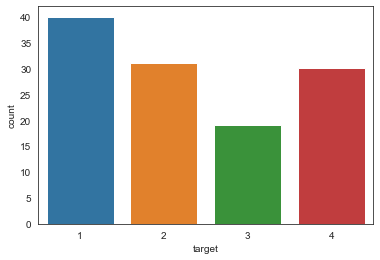

In [153]:
# Calculating the counts of each target catergory
sns.countplot(x= 'target', data = dataset )
plt.show()

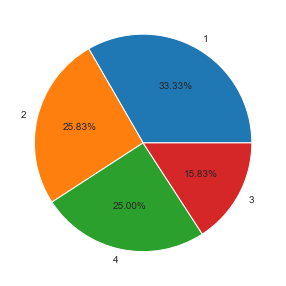

In [165]:
fig = plt.figure(figsize=(5, 5))
plt.pie(dataset.target.value_counts(), autopct='%.2f%%', labels=dataset.target.value_counts().index)
plt.show()

The graph above shows the frequency distrubiton of the target outcomes. In our population, 1/3 participants has inflamation making in the most common diseases in our dataset. Around 25% has nephritis or neither diseases and around 16% has been diagnosed with both inflamation and nephritis.

In [10]:
# 1 Temp chart
pd.DataFrame(dataset['Temp'].describe()).style.format('{:.1f}')

,Temp
count,120.0
mean,38.7
std,1.9
min,35.3
25%,37.3
50%,37.8
75%,40.4
max,41.4


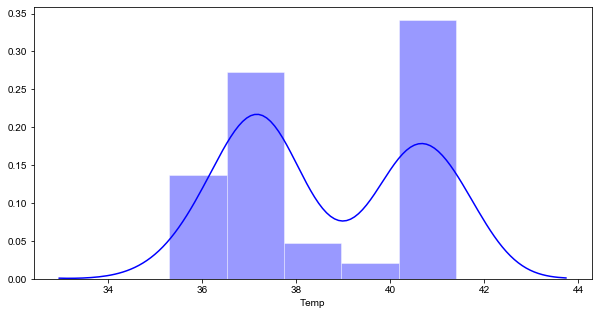

In [11]:
# 2 Temp graph
fig  = plt.subplots(1,1,figsize = (10,5))
sns.set_style("white")
sns.distplot(dataset['Temp'], kde = True, color = 'blue')
plt.show()

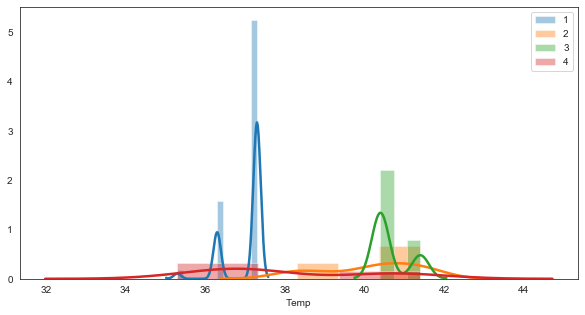

In [12]:
# 3 Temp graph
fig  = plt.subplots(1,1,figsize = (10,5))

for i in sorted(data.target.unique()):
    temp = data.query("target=={}".format(i))
    sns.distplot(temp['Temp'], label = i, hist = True, kde_kws=dict(linewidth=2.5))
plt.legend()
plt.show()

We only have one non-binary varaible in the dataset and that variable is temperature. To explore the temperature data, three differnt graphs and charts were created. The "1 Temp chart" shows the distribution of the temperature. Using the "1 Temp chart", we can conclude the temperature is skewed to the right. Even though the mean is 39C, the 25th percentile and 50th percentile is around 37C. To better see the skewness of temp distribution, a "2 Temp graph" is created. This graph shows two seperate normal distributions with means around 37C and 40C. To understand how the temperature is affecting the target column(four outcomes), "3 Temp graph" is created. This graph shows that all participants with inflamation has lower temperature (35C to 37.5C) while participants with inflamation only or both diseases have higher temperature(38.5C 41.4C). Lastly, participants without inflamation or nephritis can have low or high temperature and the cause of their temperature is not within the scope of our study.

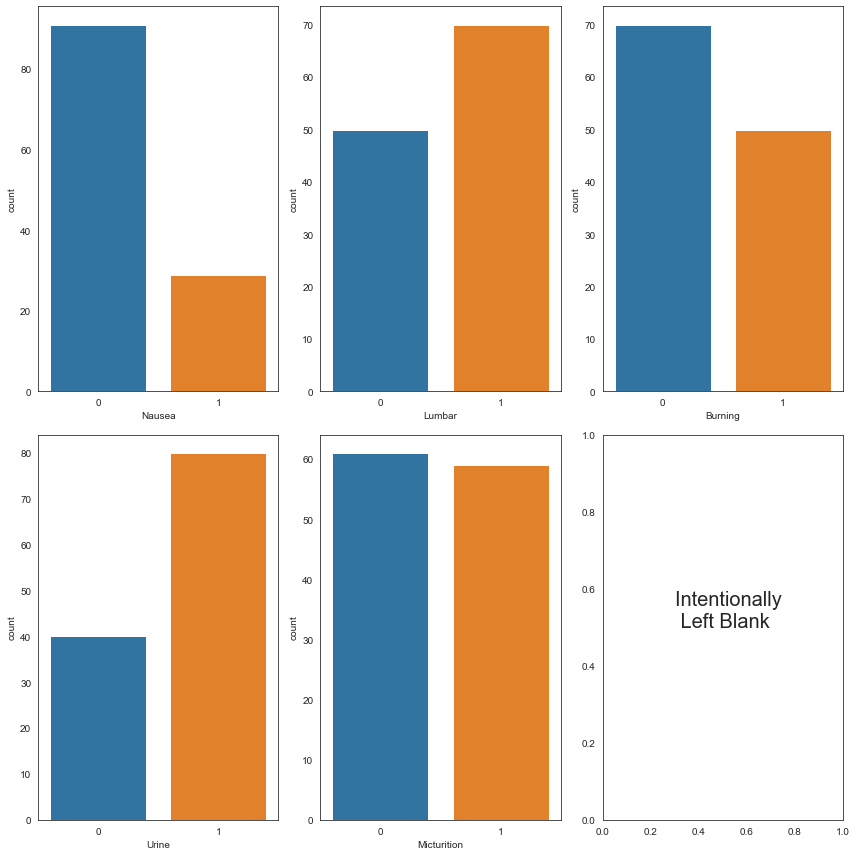

In [13]:
fig, ax = plt.subplots(2,3, figsize=(12,12), tight_layout = True)
sns.countplot(x= 'Nausea', data = dataset, ax = ax[0,0])
sns.countplot(x= 'Lumbar', data = dataset, ax = ax[0,1])
sns.countplot(x= 'Urine', data = dataset, ax = ax[1,0])
sns.countplot(x= 'Micturition', data = dataset, ax = ax[1,1])
sns.countplot(x= 'Burning', data = dataset, ax = ax[0,2])
ax[1,2].annotate("Intentionally \n Left Blank",(0.3,0.5), size = 20)
plt.show()

So far, we have looked at only one non-binary variable. The graph above shows a distribution of our binary variables. Checking the "yes" or "no" count will given an idea of how well the data is divided. If every particpant in the study has all "yes" or "no" for a particular variable then that variable isn't worth including as an input. That variable doesn't give us any new information which will help us differentiate between our four target outcomes. Micturition, Lumbar and Buring are ideal distribution of around 50% for "0" and "1." Nauseau and Urine are more realistic. If these variable had greater than 85% frequency of "0" or "yes", further digging into data would be required to determine whether re-sampling is necessary. Given that isn't the case for any of our binary variables, we can move forward with the given data. 

In [14]:
bin_vars = list(dataset.columns[1:-1])
bin_vars

['Nausea', 'Lumbar', 'Urine', 'Micturition', 'Burning']

In [15]:
dataset.head(5)

,Temp,Nausea,Lumbar,Urine,Micturition,Burning,target
0,35.3,0,1,0,0,0,4
1,35.3,0,0,1,1,1,1
2,35.3,0,1,0,0,0,4
3,36.3,0,0,1,1,1,1
4,36.3,0,1,0,0,0,4


In [16]:
def getCounts(col1, col2):
    temp = dataset.pivot_table(index = [col1], columns=[col2],values='Temp',  aggfunc='count').reset_index(drop = True).fillna(0)
    same = temp.iloc[0,0] + temp.iloc[1,1]
    not_same = temp.iloc[1,0] + temp.iloc[0,1]
    return same, not_same

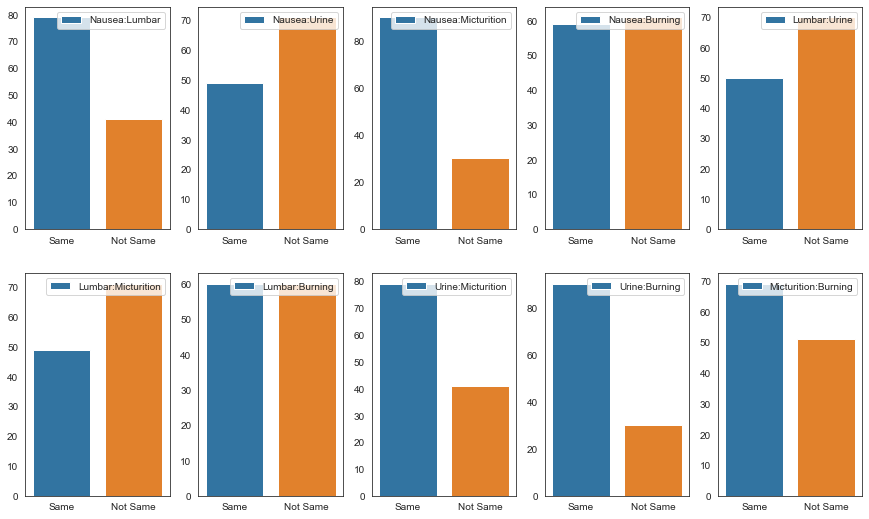

In [17]:
fig, ax = plt.subplots(2,5, figsize = (15,9))
counter = 0
for i, j in enumerate(bin_vars[:-1]):
    for k in bin_vars[i+1:]:
        sns.barplot(x=['Same','Not Same'], y=getCounts(j,k), label = "{}:{}".format(j,k), ax = ax[counter//5][counter%5])
        ax[counter//5][counter%5].legend()
        counter += 1

The graphs above are testing the correlation between two binary input variables. The goal is remove any input variables at the mutually exclusive or subsets of each other. There are five binary input variables so 10 possible combinations (5 choose 2). None of the bars "same" or "different" are non-existent concluding that none of the inputs are mutually exclusive or subsets of each other.

However, there are evidences that "Nausea" is the one variables which is closely associated with other variables. I.e. Information from Nausea is same as Micturitionin most of the cases. We take this into consideration while selecting model parameters in the modeling part.

# Traning and Test  Dataset Split

In [26]:
# Seperating out input variables vs. output variable
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

#  Model Deployment

By exploring the data, it can be easily concluded that the best fit for the data will be a classification model. There will be four classes (target column). Below are four classification model we will build and then compare the accuracy to determine and the best model.
Models:
K nearest neighbor (KNN)
Decision Tree (DT)
Support Vector Machines (SVM)
Random Forest (RF)

##### 1. K Nearest Neighbor Model

In [28]:
classifier_knn = KNeighborsClassifier(n_neighbors=4)
classifier_knn.fit(X_train, y_train)
y_pred_knn = classifier_knn.predict(X_test)
y_pred_knn_train = classifier_knn.predict(X_train)
print('K Nearest Neighbor Accuracy Score on Test Set:', end = ' ')
print(accuracy_score(y_test, y_pred_knn)*100)
print('K Nearest Neighbor Accuracy Score on Training Set:', end = ' ')
print(accuracy_score(y_train, y_pred_knn_train)*100)

K Nearest Neighbor Accuracy Score on Test Set: 100.0
K Nearest Neighbor Accuracy Score on Training Set: 100.0


##### Since Test accuracy is as high as Training Accuracy, it can be inferred that model doesn't seem to overfit on training data. However, this can be further analyzed using Cross Validation (Leave One Out Analylsis). This will help us determinge if the model is dependent on train test split or is sensitive to any specific data points.  

##### 2. Decision Tree

In [29]:
classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier_dt.fit(X_train, y_train)
y_pred_dt = classifier_dt.predict(X_test)
y_pred_dt_train = classifier_dt.predict(X_train)
print('Decision Tree Accuracy Score on Test Set:', end = ' ')
print(accuracy_score(y_test, y_pred_dt)*100)
print('Decision Tree Accuracy Score on Training Set:', end = ' ')
print(accuracy_score(y_train, y_pred_dt_train)*100)

Decision Tree Accuracy Score on Test Set: 100.0
Decision Tree Accuracy Score on Training Set: 100.0


In [30]:
# Reviewing feature importance of the independent variables
dict(zip(X_train.columns,classifier_dt.feature_importances_))

{'Temp': 0.391432615327524,
 'Nausea': 0.0,
 'Lumbar': 0.14543992564769634,
 'Urine': 0.3768972978021139,
 'Micturition': 0.08623016122266576,
 'Burning': 0.0}

##### As shown from the above feature importance scores, it appears Nausea and Burning Variables do not add any descrimination power for the classification problem. We want to further analyze the decision pathto confirm the validity of the assumption. Plotting the decision tree below

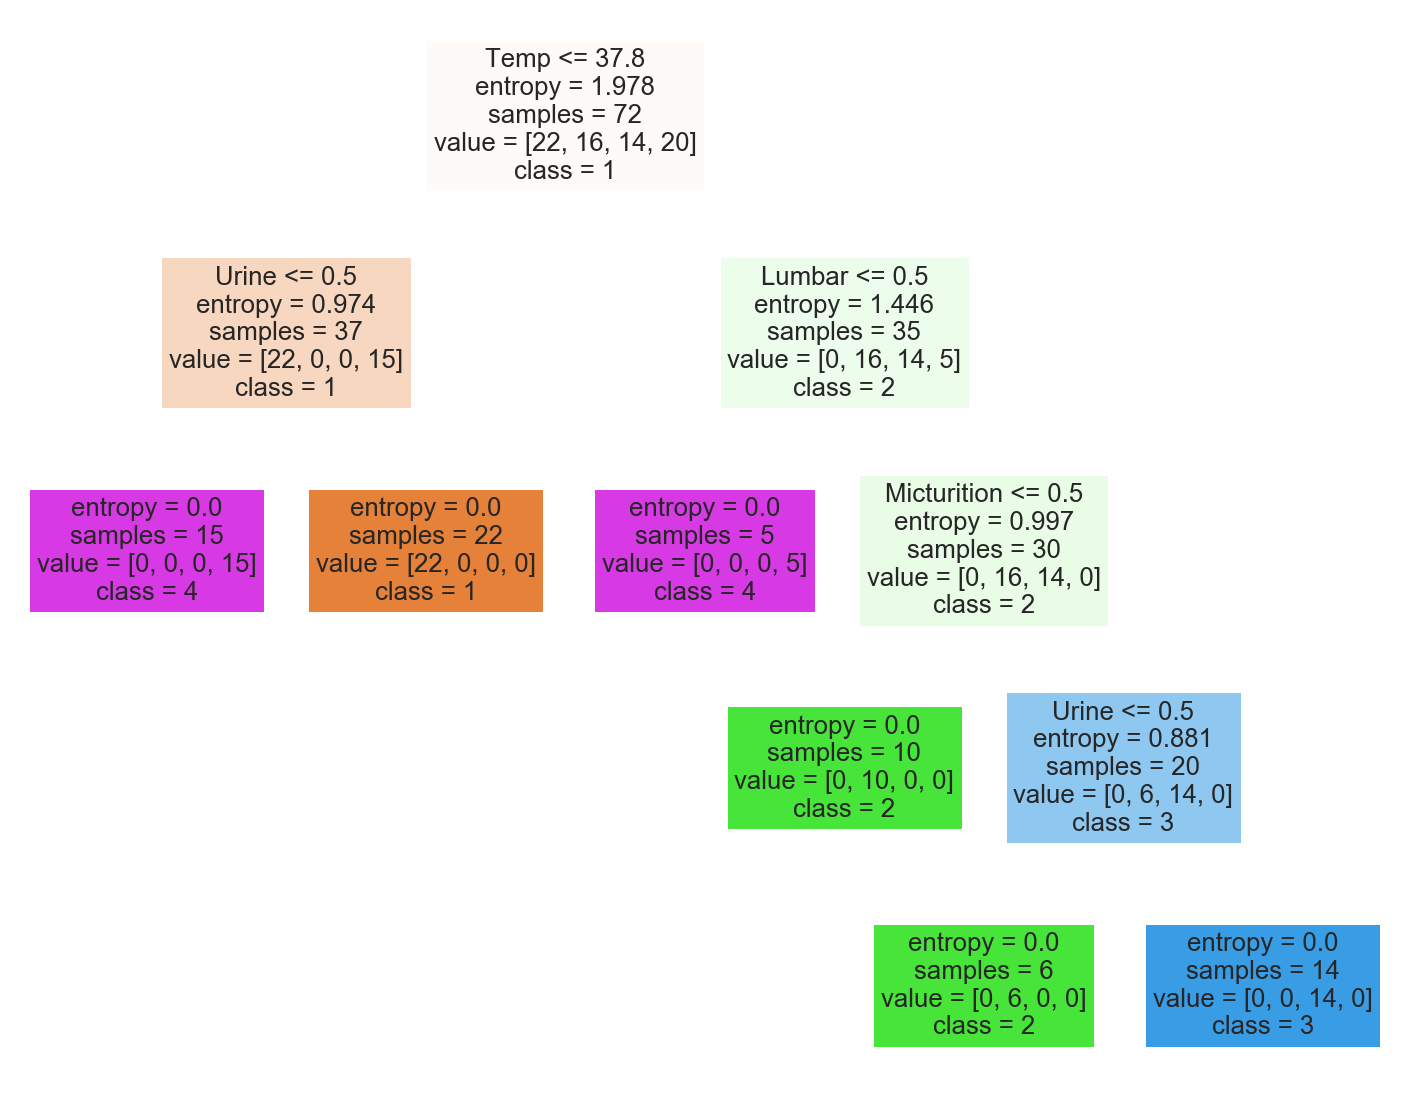

In [31]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(classifier_dt, 
                   feature_names=X_train.columns,  
                   class_names=['1','2','3','4'],
                   filled=True)

##### 3. Support Vector Machine

In [32]:
classifier_svc = SVC(kernel = 'linear', verbose = 1, random_state = 0)
classifier_svc.fit(X_train, y_train)
y_pred_svc = classifier_svc.predict(X_test)
y_pred_svc_train = classifier_svc.predict(X_train)
print('\nSupport Vector Machine Accuracy Score on Test Set:', end = ' ')
print(accuracy_score(y_test, y_pred_svc)*100)
print('Support Vector Machine Accuracy Score on Training Set:', end = ' ')
print(accuracy_score(y_train, y_pred_svc_train)*100)

[LibSVM]
Support Vector Machine Accuracy Score on Test Set: 100.0
Support Vector Machine Accuracy Score on Training Set: 100.0


##### Taking linear kernel to avoid overfitting for SVM. There are very high chances of overfitting using RBF kernel with SVM if there are  outliers as RBF kernel can be non-linear in nature. 

##### 4. Random Forest

In [76]:
classifier_rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0, max_features='auto')
classifier_rf.fit(X_train, y_train)
y_pred_rf = classifier_rf.predict(X_test)
y_pred_rf_train = classifier_rf.predict(X_train)
print('Random Forest on Accuracy Score Test Set:', end = ' ')
print(accuracy_score(y_test, y_pred_rf)*100)
print('Random Forest on Accuracy Score Training Set:', end = ' ')
print(accuracy_score(y_train, y_pred_svc_train)*100)

Random Forest on Accuracy Score Test Set: 100.0
Random Forest on Accuracy Score Training Set: 100.0


In [34]:
# Reviewing feature importance of the independent variables
dict(zip(X_train.columns,classifier_rf.feature_importances_))

{'Temp': 0.21729528783700716,
 'Nausea': 0.13471951751607755,
 'Lumbar': 0.19161469929208425,
 'Urine': 0.24332617583790908,
 'Micturition': 0.15795353484371805,
 'Burning': 0.055090784673203996}

##### Random Forest

###### Each model is showing an accuracy of 100%. The test an overfitting model, accuracy score on both the training and test test were calculated. If the training set had 100% accuracy and the test set had less than 90% accuracy, the model would become disqualified. Currently, all four models are in the running. To figure out the best model, we will run cross validation tests. 

# Model Robustness Testing/Sensitivity Check

K Nearest Neighbor Model: Cross Validation, Confusion Matrix, Recall, Accuracy Scores

In [35]:
num_of_cross_val = 3

Cross Validation Scores: 81.6% accuracy with a standard deviation of 5.4%
 
Recall Score: 81.7%
 
Accuracy Percentage: 81.7%


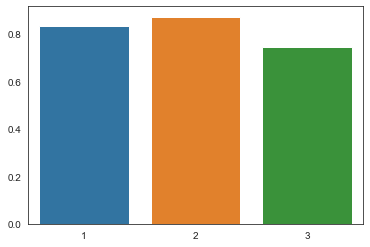

,1,2,3,4
1,40,0,0,0
2,7,19,5,0
3,0,0,19,0
4,0,10,0,20


In [61]:
labels = [1,2,3,4]
scores_knn = cross_val_score(classifier_knn, X, y, cv=num_of_cross_val)
y_pred_knn = cross_val_predict(classifier_knn, X, y, cv=num_of_cross_val)
cm_knn = confusion_matrix(y, y_pred_knn)
recall_knn = recall_score(y, y_pred_knn, average = 'micro')
print("Cross Validation Scores:", end = ' ')
print("{:.1%} accuracy with a standard deviation of {:.1%}".format(scores_knn.mean(), scores_knn.std()))
print(" ")
print("Recall Score:", end = ' ')
print("{:.1%}".format(recall_knn))
print(" ")
print("Accuracy Percentage:", end = ' ')
print("{:.1%}".format(accuracy_score(y, y_pred_knn)))
sns.barplot(x = list(range(1,num_of_cross_val + 1)),y=scores_knn)
plt.show()
pd.DataFrame(data = cm_knn,index=range(1,5), columns=range(1,5))


Decision Tree: Cross Validation, Confusion Matrix, Recall, Accuracy Scores

Cross Validation Scores:
85.9% accuracy with a standard deviation of 10.6%
 
Recall Score: 85.8%
 
Accuracy Percentage: 85.8%


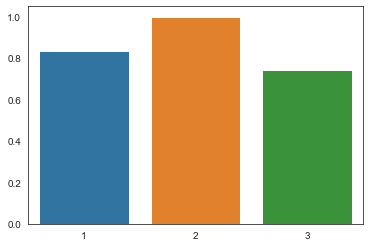

,1,2,3,4
1,40,0,0,0
2,0,24,0,7
3,0,0,19,0
4,0,10,0,20


In [115]:
scores_dt = cross_val_score(classifier_dt, X, y, cv=num_of_cross_val)
y_pred_dt = cross_val_predict(classifier_dt, X, y, cv=num_of_cross_val)
cm_dt = confusion_matrix(y, y_pred_dt)
recall_dt = recall_score(y, y_pred_dt, average = 'micro')
print("Cross Validation Scores:")
print("{:.1%} accuracy with a standard deviation of {:.1%}".format(scores_dt.mean(), scores_dt.std()))
print(" ")
print("Recall Score:", end = ' ')
print("{:.1%}".format(recall_dt))
print(" ")
print("Accuracy Percentage:", end = ' ')
print("{:.1%}".format(accuracy_score(y, y_pred_dt)))
sns.barplot(x = list(range(1,num_of_cross_val + 1)),y=scores_dt)
plt.show()
pd.DataFrame(data = cm_dt,index=range(1,5), columns=range(1,5))

Support Vector Machine: Cross Validation, Confusion Matrix, Recall, Accuracy Scores

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
Cross Validation Scores:
85.9% accuracy with a standard deviation of 10.6%
 
Recall Score: 85.8%
 
Accuracy Percentage: 85.8%


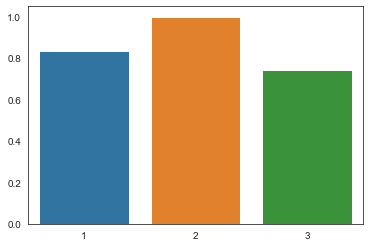

,1,2,3,4
1,40,0,0,0
2,7,24,0,0
3,0,0,19,0
4,0,10,0,20


In [70]:
scores_svc = cross_val_score(classifier_svc, X, y, cv=num_of_cross_val)
y_pred_svc = cross_val_predict(classifier_svc, X, y, cv=num_of_cross_val)
cm_svc = confusion_matrix(y, y_pred_svc)
recall_svc = recall_score(y, y_pred_dt, average = 'micro')
print("\nCross Validation Scores:")
print("{:.1%} accuracy with a standard deviation of {:.1%}".format(scores_svc.mean(), scores_svc.std()))
print(" ")
print("Recall Score:", end = ' ')
print("{:.1%}".format(recall_svc))
print(" ")
print("Accuracy Percentage:", end = ' ')
print("{:.1%}".format(accuracy_score(y, y_pred_svc)))
sns.barplot(x = list(range(1,num_of_cross_val + 1)),y=scores_svc)
plt.show()
pd.DataFrame(data = cm_svc,index=range(1,5), columns=range(1,5))

Random Forest: Cross Validation, Confusion Matrix, Recall, Accuracy Scores

Cross Validation Scores:
91.5% accuracy with a standard deviation of 12.1%
 
Recall Score: 85.8%
 
Accuracy Percentage: 91.7%


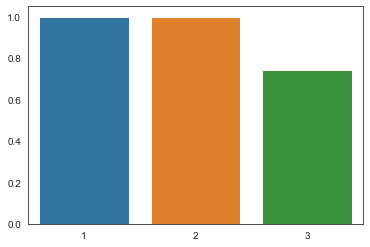

,1,2,3,4
1,40,0,0,0
2,0,31,0,0
3,0,0,19,0
4,10,0,0,20


In [77]:
scores_rf = cross_val_score(classifier_rf, X, y, cv=num_of_cross_val)
y_pred_rf = cross_val_predict(classifier_rf, X, y, cv=num_of_cross_val)
cm_rf = confusion_matrix(y, y_pred_rf)
recall_svc = recall_score(y, y_pred_dt, average = 'micro')
print("Cross Validation Scores:")
print("{:.1%} accuracy with a standard deviation of {:.1%}".format(scores_rf.mean(), scores_rf.std()))
print(" ")
print("Recall Score:", end = ' ')
print("{:.1%}".format(recall_svc))
print(" ")
print("Accuracy Percentage:", end = ' ')
print("{:.1%}".format(accuracy_score(y, y_pred_rf)))
sns.barplot(x = list(range(1,num_of_cross_val + 1)),y=scores_rf)
plt.show()
pd.DataFrame(data = cm_rf,index=range(1,5), columns=range(1,5))

# Model Evaluation

In [79]:
models = ["KNN", "DT", "SVM", "RF"]
accuracy =[scores_knn.mean(), scores_dt.mean(),scores_svc.mean(), scores_rf.mean()]
std = [scores_knn.std(), scores_dt.std(),scores_svc.std(), scores_rf.std()]

# Nirja  - Pick one from below! 

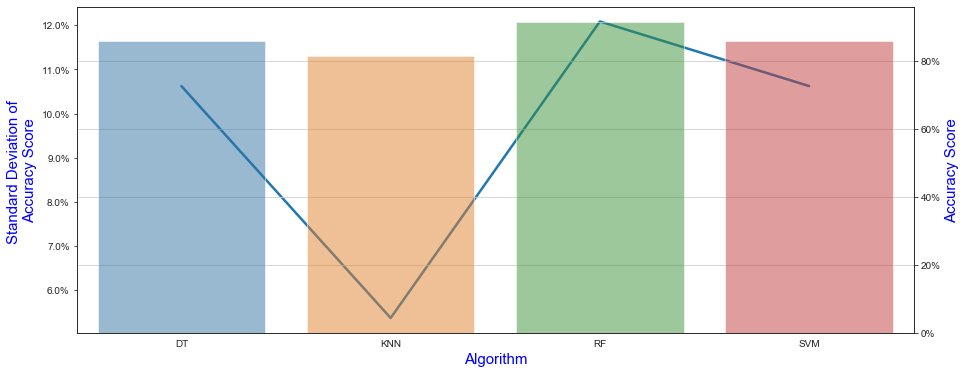

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

sns.lineplot(x=models, y=std, ax=ax, linewidth = 2.5)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax2 = ax.twinx()
sns.barplot(x=models, y=accuracy,  ax=ax2, alpha=0.5,order = [ 'DT','KNN',  'RF','SVM'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

ax.set_xlabel('Algorithm', color = 'blue', size = 15)
ax.set_ylabel("Standard Deviation of \nAccuracy Score",color = 'blue', size = 15)
ax2.set_ylabel("Accuracy Score",color = 'blue', size = 15)
plt.grid()
plt.show()

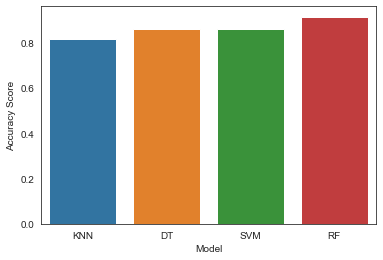

In [83]:
sns.barplot(x = models, y= accuracy)
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.show()

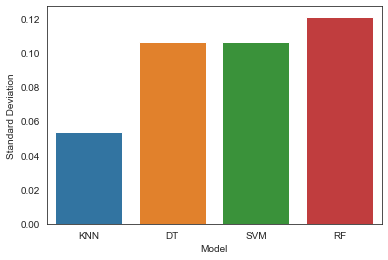

In [84]:
sns.barplot(x = models, y = std)
plt.xlabel("Model")
plt.ylabel("Standard Deviation")
plt.show()

##### Using cross validation, it can be concluded that Random Forest (RF) has the hightest accuracy and standard deviation at 92% and 12% respectively.K nearest neighbor has the lowest accuracy score and standard deviation at 81% and 4% respectively. 

##### Given that Random Forest is not robust based on cross validation accuracy standard deviation, we'd choose either Decision Tree or Support Vector Machine as our chanmpion model.

##### SVM and DT are par in terms of accuracy and robustness. Hence any model would be fine.

##### However, Given the structure of the Decision tree, it is easier to make business sense and to explain the decisionpath, we chose Decision Tree as our final model.

# Model Selection and Finalization (Sensitivity and Accuracy Matrix)

##### As analyzed in the previous analysis, that variables "Nausea" and "Burning" doesnt have any descrimination power, we will exclude those variables and retrain our model which will be simplar but would yield same accuracy. 

In [98]:
X = dataset.iloc[:,[0,2,3,4]]
y = dataset.iloc[:,[6]]

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 45)

In [106]:
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 45)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=45, splitter='best')

In [120]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels)
print('Accuary Score for Decision Tree based on Train-Test Split:', end = ' ')
print ("{:.1%} \nBelow is the confusion matrix".format(accuracy_score(y_test, y_pred)))
pd.DataFrame(data = cm,index=range(1,5), columns=range(1,5))

Accuary Score for Decision Tree based on Train-Test Split: 100.0% 
Below is the confusion matrix


,1,2,3,4
1,20,0,0,0
2,0,10,0,0
3,0,0,7,0
4,0,0,0,11


Cross Validation Scores Based on 3 Fold Cross Validation (67%-33% Split):
85.9% accuracy with a standard deviation of 10.6%
 
Recall Score: 85.8%
 
Accuracy Percentage: 85.8%


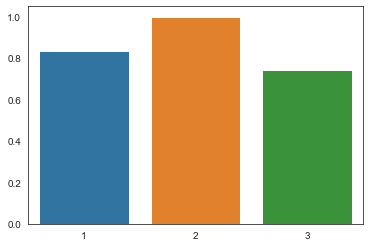

,1,2,3,4
1,40,0,0,0
2,7,24,0,0
3,0,0,19,0
4,0,10,0,20


In [123]:
scores = cross_val_score(classifier, X, y, cv=num_of_cross_val)
y_pred = cross_val_predict(classifier, X, y, cv=num_of_cross_val)

cm = confusion_matrix(y, y_pred)
recall = recall_score(y, y_pred, average = 'micro')
print("Cross Validation Scores Based on 3 Fold Cross Validation (67%-33% Split):")
print("{:.1%} accuracy with a standard deviation of {:.1%}".format(scores.mean(), scores.std()))
print(" ")
print("Recall Score:", end = ' ')
print("{:.1%}".format(recall))
print(" ")
print("Accuracy Percentage:", end = ' ')
print("{:.1%}".format(accuracy_score(y, y_pred)))
sns.barplot(x = list(range(1,num_of_cross_val + 1)),y=scores)
plt.show()
pd.DataFrame(data = cm,index=range(1,5), columns=range(1,5))

##### As see above, after removing the two variables, we did not compromise on Model Accuracy or Robustness. Hence we believe this model is thhe best possible fit for the training dataset we have.

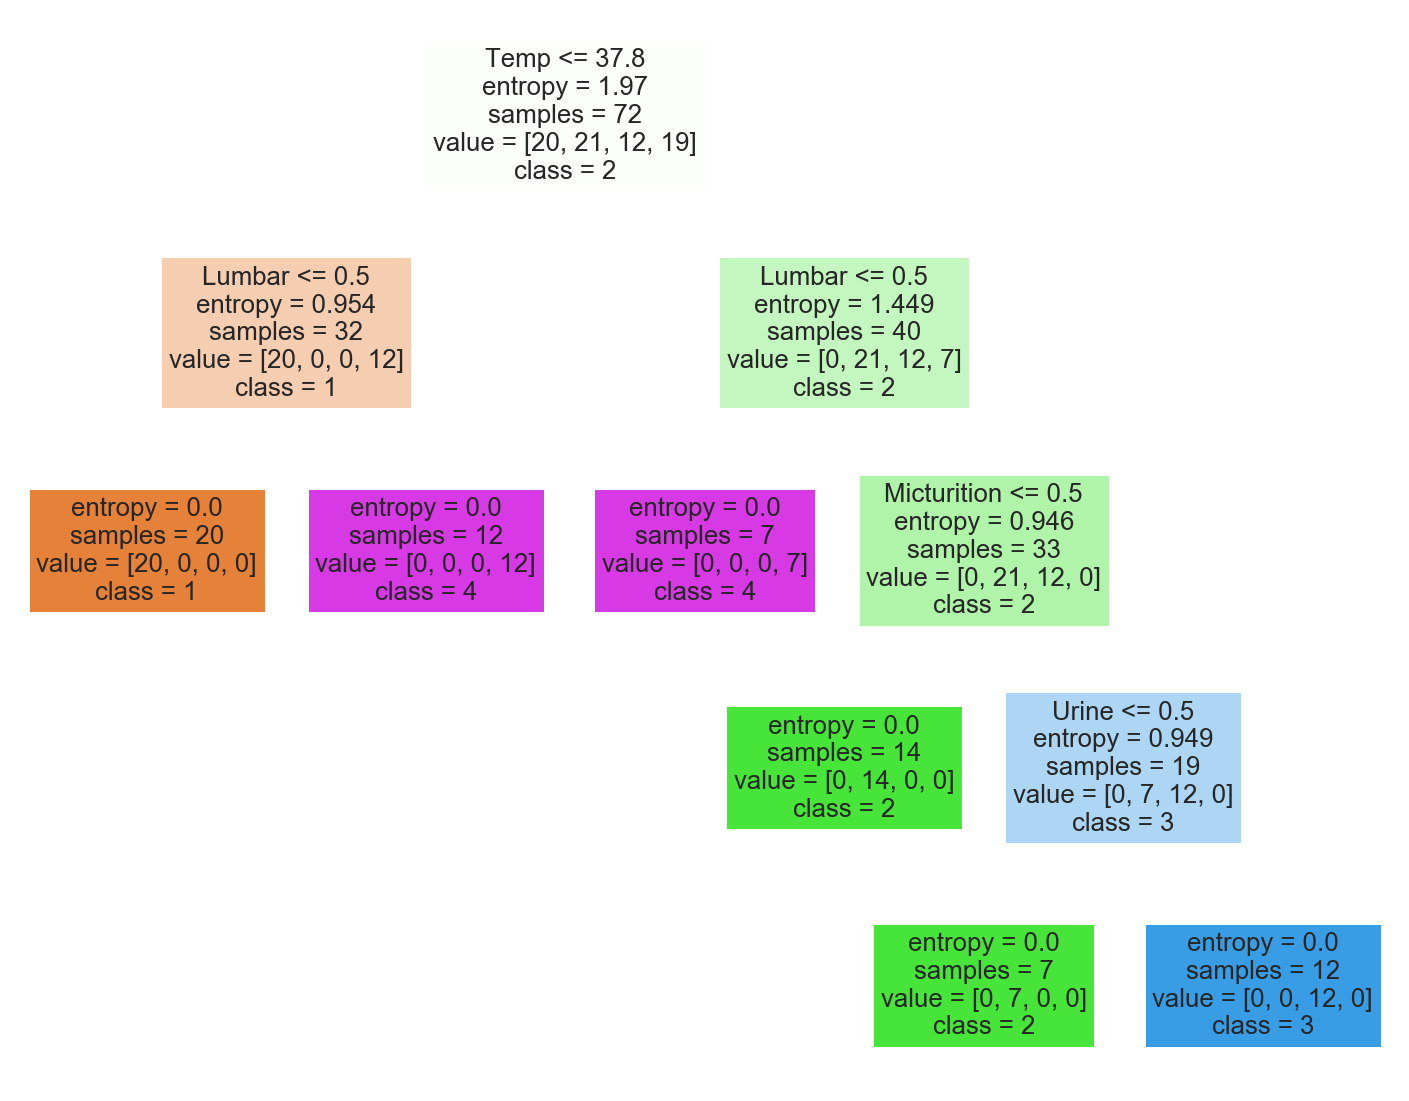

In [124]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(classifier, 
                   feature_names=X_train.columns,  
                   class_names=['1','2','3','4'],
                   filled=True)

### ADHOC! To be deleted before submission 